In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import shap

sns.set_style("whitegrid")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
file_path = '/content/drive/My Drive/Base.csv'
df = pd.read_csv(file_path)

# Showing Example of what data looks like
print(f"Dataset Shape: {df.shape}")
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Shape: (1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


/tmp/ipython-input-3920746368.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')


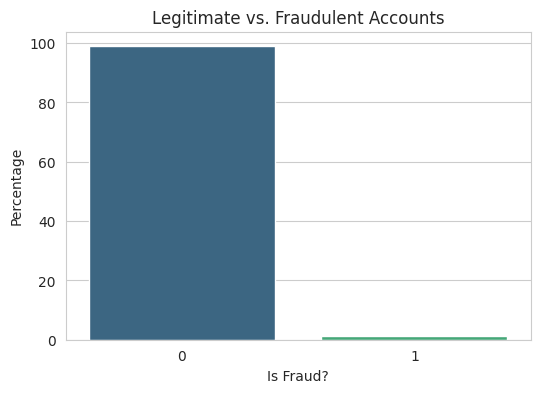

Legitimate Accounts: 98.897%
Fraudulent Accounts: 1.103%


In [ ]:
# Showing the class imbalance
target_col = 'fraud_bool'

fraud_counts = df[target_col].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')
plt.title('Legitimate vs. Fraudulent Accounts')
plt.xlabel('Is Fraud?')
plt.ylabel('Percentage')
plt.show()

print(f"Legitimate Accounts: {fraud_counts[0]:.3f}%")
print(f"Fraudulent Accounts: {fraud_counts[1]:.3f}%")

In [ ]:
# Pre processing

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# I am filling in missing columns (-1)
missing_minus_one_cols = ["prev_address_months_count", "current_address_months_count"]
for c in missing_minus_one_cols:
    if c in df.columns:
        df[c + "_is_missing"] = (df[c] == -1).astype(int)
        df[c] = df[c].replace(-1, np.nan)

categorical_features = [
    "payment_type", "employment_status", "housing_status",
    "source", "device_os", "month",
]

numeric_features = [
    "income", "name_email_similarity",
    "prev_address_months_count", "current_address_months_count",
    "customer_age", "days_since_request", "intended_balcon_amount",
    "zip_count_4w", "velocity_6h", "velocity_24h", "velocity_4w",
    "bank_branch_count_8w", "date_of_birth_distinct_emails_4w",
    "credit_risk_score", "bank_months_count", "proposed_credit_limit",
    "session_length_in_minutes", "device_distinct_emails_8w", "device_fraud_count",
    "has_other_cards", "foreign_request", "keep_alive_session",
    "email_is_free", "phone_home_valid", "phone_mobile_valid",
]
# Add missing flags to numeric
for c in missing_minus_one_cols:
    miss = c + "_is_missing"
    if miss in df.columns:
        numeric_features.append(miss)


numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]
log1p_numeric = [
    "zip_count_4w", "bank_branch_count_8w",
    "velocity_6h", "velocity_24h", "velocity_4w",
    "device_distinct_emails_8w", "device_fraud_count",
    "date_of_birth_distinct_emails_4w",
]
log1p_numeric = [c for c in log1p_numeric if c in numeric_features]
normal_numeric = [c for c in numeric_features if c not in log1p_numeric]

safe_log1p = FunctionTransformer(
    lambda X: np.log1p(np.clip(X, 0, None)),
    feature_names_out="one-to-one"
)

# transformers
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

log_numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", safe_log1p),
])

normal_numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num_log", log_numeric_transformer, log1p_numeric),
        ("num", normal_numeric_transformer, normal_numeric),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)
# dropping fraud bool from input data
drop_cols = ["fraud_bool"]
for id_col in ["device_id", "session_id"]:
    if id_col in df.columns:
        drop_cols.append(id_col)

X = df.drop(drop_cols, axis=1)
y = df["fraud_bool"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

ohe_feature_names = preprocessor.named_transformers_["cat"] \
    .named_steps["encoder"].get_feature_names_out(categorical_features)

all_feature_names = list(log1p_numeric) + list(normal_numeric) + list(ohe_feature_names)

print("Total features :", len(all_feature_names))



Total features : 61


In [ ]:
# Downsampling as 1 million samples takes forever, also increasing fraudulent accounts

import pandas as pd
from sklearn.utils import resample

print("Original Fraud Rate:", y_train.mean())

train_df_temp = X_train.copy()
train_df_temp['fraud_bool'] = y_train

# 2. Separate into legit and fraud
df_majority = train_df_temp[train_df_temp.fraud_bool == 0]
df_minority = train_df_temp[train_df_temp.fraud_bool == 1]

# Downsamples the legit
ratio = 10
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority) * ratio,
    random_state=42
)

# Then combines
df_upsampled = pd.concat([df_majority_downsampled, df_minority])
y_train_new = df_upsampled.fraud_bool
X_train_new = df_upsampled.drop('fraud_bool', axis=1)

print(f"New data shape: {X_train_new.shape}")
print(f"New fraud rate: {y_train_new.mean():.4f}")
X_train_processed = preprocessor.fit_transform(X_train_new)
y_train = y_train_new

Original Fraud Rate: 0.01102875
New data shape: (97053, 33)
New fraud rate: 0.0909


In [ ]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import ParameterGrid
import pandas as pd

# Hyperparameter tuning!
param_grid = {
    'n_estimators': [200],
    'max_depth': [10,15,20, 25],
    'min_samples_leaf': [2,4,7,10],
    'class_weight': ['balanced_subsample']
}

best_score = 0
best_params = {}
results = []

print(f"{'Depth':<10} | {'Leaf':<10} | {'Weight':<20} | {'PR-AUC Score':<10}")
print("-" * 65)

for params in ParameterGrid(param_grid):
    rf = RandomForestClassifier(
        **params,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train_processed, y_train)
    y_probs = rf.predict_proba(X_test_processed)[:, 1]

    # Calculate AUC
    score = average_precision_score(y_test, y_probs)

    # Print and Append
    print(f"{params['max_depth']:<10} | {params['min_samples_leaf']:<10} | {str(params['class_weight']):<20} | {score:.4f}")

    results.append({'params': params, 'score': score})

    # Save the winner
    if score > best_score:
        best_score = score
        best_params = params
        best_model = rf

print("-" * 65)
print(f"Best PR-AUC = {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Set the main model as the one to use!
rf_model = best_model

Depth      | Leaf       | Weight               | PR-AUC Score
-----------------------------------------------------------------
10         | 2          | balanced_subsample   | 0.1364
10         | 4          | balanced_subsample   | 0.1373
10         | 7          | balanced_subsample   | 0.1387
10         | 10         | balanced_subsample   | 0.1399
15         | 2          | balanced_subsample   | 0.1308
15         | 4          | balanced_subsample   | 0.1370
15         | 7          | balanced_subsample   | 0.1444
15         | 10         | balanced_subsample   | 0.1452
20         | 2          | balanced_subsample   | 0.1366
20         | 4          | balanced_subsample   | 0.1467
20         | 7          | balanced_subsample   | 0.1492
20         | 10         | balanced_subsample   | 0.1481
25         | 2          | balanced_subsample   | 0.1408
25         | 4          | balanced_subsample   | 0.1480
25         | 7          | balanced_subsample   | 0.1446
25         | 10         | balanc

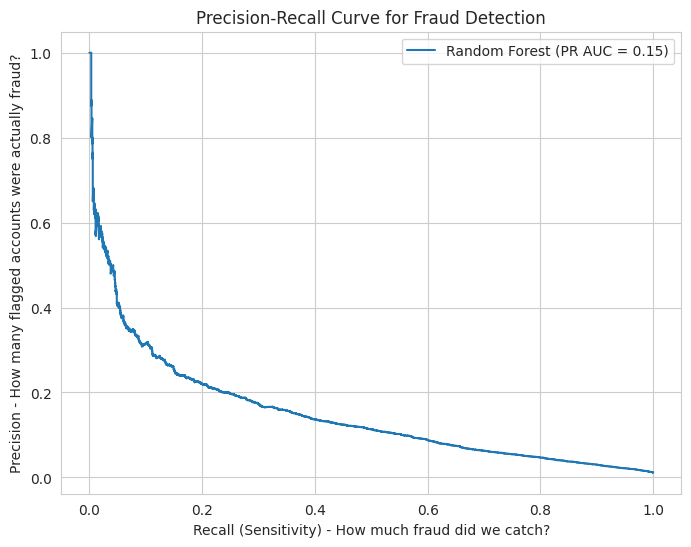

In [ ]:
# Cell 6: Precision Recall Curve


y_scores = rf_model.predict_proba(X_test_processed)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall (Sensitivity) - How much fraud did we catch?')
plt.ylabel('Precision - How many flagged accounts were actually fraud?')
plt.title('Precision-Recall Curve for Fraud Detection')
plt.legend()
plt.show()

Threshold  | Precision  | Recall    
------------------------------------
0.2        | 0.0314     | 0.8903
0.3        | 0.0479     | 0.7956
0.4        | 0.0669     | 0.6754
0.5        | 0.0941     | 0.5743
0.6        | 0.1254     | 0.4438
0.7        | 0.1663     | 0.3073
0.8        | 0.2362     | 0.1704
------------------------------------


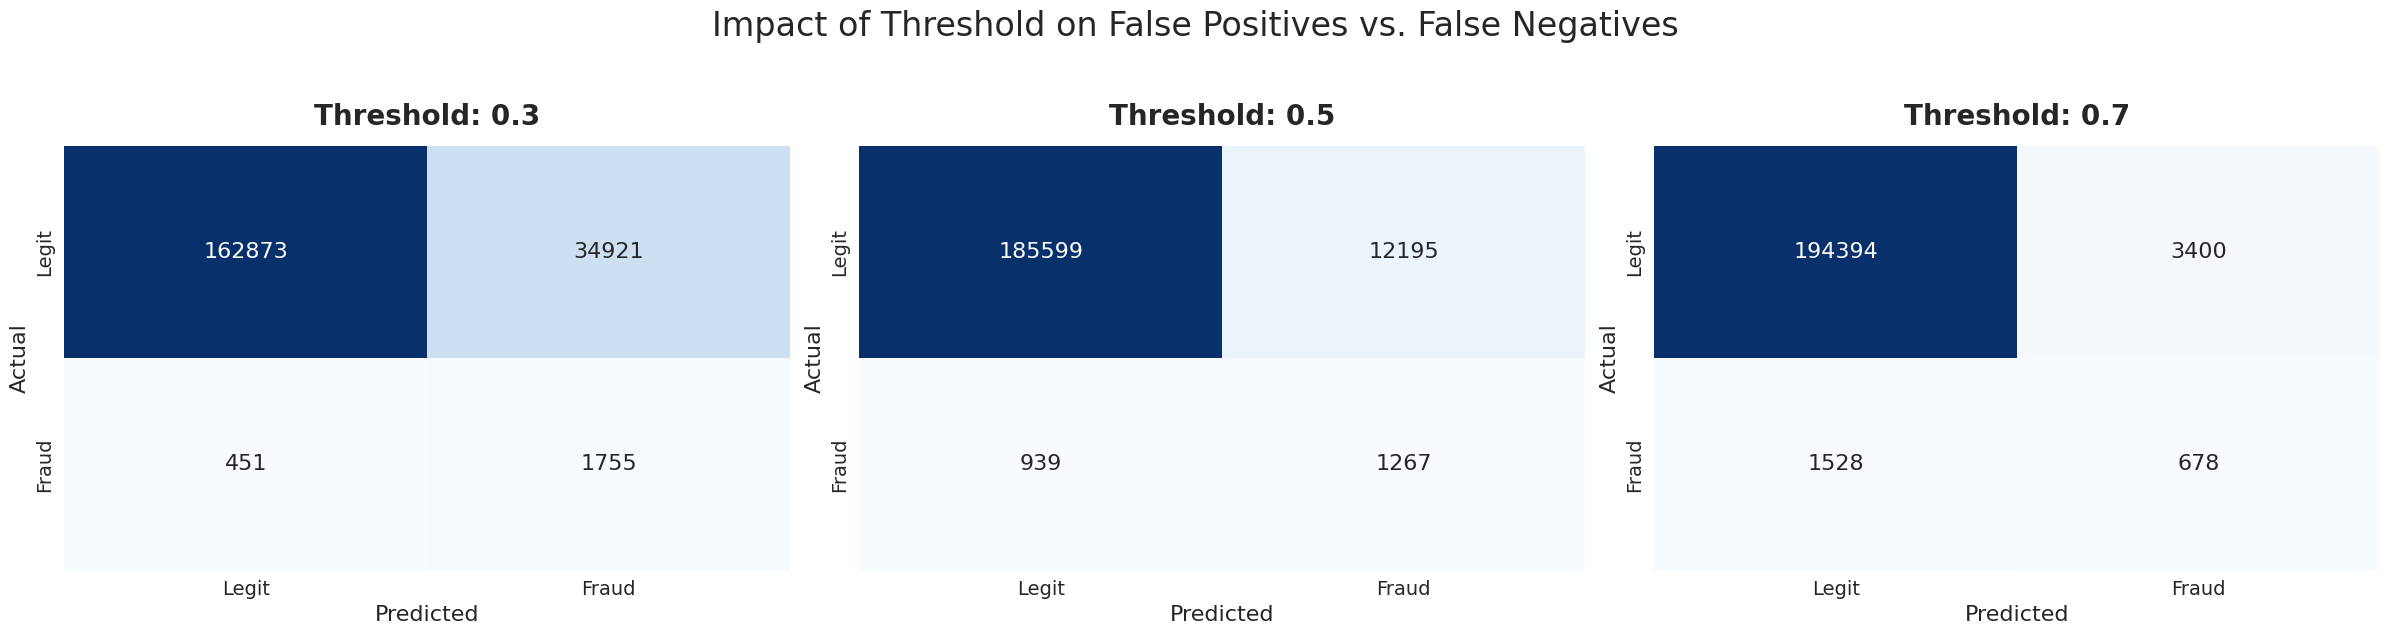

In [ ]:
# Cell: Evaluation without F1-Score (Business Focus)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
#Thought I would print a list of many values
thresholds = np.arange(0.2, 0.9, 0.1)
print(f"{'Threshold':<10} | {'Precision':<10} | {'Recall':<10}")
print("-" * 36)

for thresh in thresholds:
    y_pred_loop = (y_scores >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_loop)
    rec = recall_score(y_test, y_pred_loop)
    print(f"{thresh:.1f}        | {prec:.4f}     | {rec:.4f}")

print("-" * 36)

plot_thresholds = [0.3, 0.5, 0.7]

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, thresh in enumerate(plot_thresholds):
    y_pred_viz = (y_scores >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_viz)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'],
                ax=axes[i], cbar=False, annot_kws={"size": 16})

    axes[i].set_title(f'Threshold: {thresh}', fontsize=20, fontweight='bold', pad=15)
    axes[i].set_ylabel('Actual', fontsize=16)
    axes[i].set_xlabel('Predicted', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=14)

plt.suptitle("Impact of Threshold on False Positives vs. False Negatives", fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
import shap
import pandas as pd
import numpy as np

X_test_sample_array = X_test_processed[:500]
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample_array, check_additivity=False)
vals_to_plot = shap_values[:, :, 1]
feature_names = all_feature_names
mean_abs_shap = np.abs(vals_to_plot).mean(axis=0)

imp = (pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
       }))

imp = imp.sort_values("mean_abs_shap", ascending=False)

display(imp.head(25))

,feature,mean_abs_shap
39,housing_status_BA,0.084500
51,device_os_windows,0.058582
9,name_email_similarity,0.040364
21,keep_alive_session,0.039151
23,phone_home_valid,0.037192
11,current_address_months_count,0.034061
8,income,0.033392
15,credit_risk_score,0.029792
19,has_other_cards,0.029639
25,prev_address_months_count_is_missing,0.029133
